# Wine Quality assesment Through Chemical Analysis
## Supervised Learning Algorithm Comparison
### Supervised Learning Final Project 2/24/2022

Wine is a luxury product enjoyed around the globe, fostering a set of highly demanding professions to produce the end product. However wine has always been a point of contention in terms of identifying quality, much of the current determination process is subjective and prone to relying on pedigree and confirmation bias.
By investigating if chemical analysis can be used to predict the subjective quality of wine, we may be able to create a powerful tool for vintners, sommeliers, and retail outlets who could leverage this information for their respective trades.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from imblearn.over_sampling import SMOTE

## Exploratory Data Analysis

The data for this project can be found here: https://www.kaggle.com/yasserh/wine-quality-dataset

In [2]:
df = pd.read_csv(".//wine_quality//WineQT.csv", index_col = "Id")

Once the data has been read in we can see that the target variable for our analysis will be the quality variable, and the other features will be used for predictive purchases.

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


The data set only contains 1143 data points which is small for most machine learning algorithms and we will see later on that the distribution of those data points causes some problems as well. So right off the bat we are going to think that the predictive power of our models will be somewhat lacking unless there is a very clear cut differentiation between points.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143 entries, 0 to 1597
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 116.1 KB


From the data information we can see that all of the entries are complete on all acounts, so we don't need to worry about how to handle Null values. This will help minimize some of the impact of our small data set.

In [5]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


We can see from the statistical description of each of the predictive features that the values are not normalized, which for some of our machine learning algorithms will need to be corrected. But first lets explore the data a bit more before we decide how to normalize the data.

<AxesSubplot:>

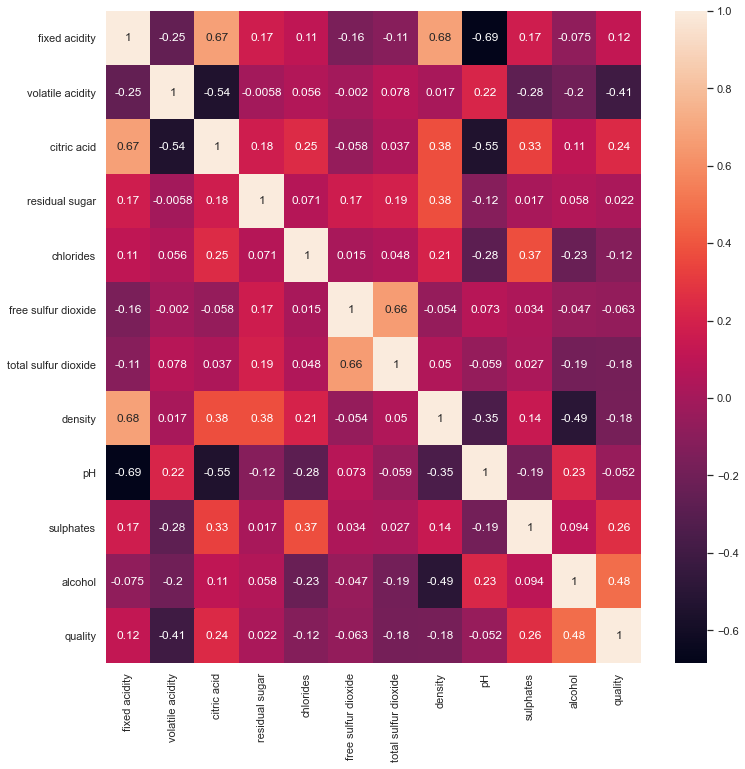

In [6]:
sns.set(rc={"figure.figsize":(12, 12)})
sns.set_palette(sns.color_palette("hls", 8))
sns.heatmap(df.corr(), annot = True)

In the above heatmap we are concerned with the correlation between quality and the predictive feature. As an arbitrary cut off point we are going to remove an predictive feature with a correlation between -.1 and .1
This includes "free sulfur dioxide", "residual sugar", and "pH".

The function visualize columns will be used to establish the ground work for drawing conclusions about the distributions, outliers, and nature of each of the predictive variables as well as visualize the relationship between quality and the feature in question.

In [7]:
def visualize_column(column):
    sns.set_palette(sns.color_palette("hls", 8))
    plt.figure(figsize = (15, 8))
    plt.subplot(1,4,1)
    plt.title(f'Histogram of {column}')
    df[column].plot(kind='hist')
    
    plt.subplot(1,4,2)
    plt.title(f'Density plot of {column}')
    sns.kdeplot(data = df[column])
    
    plt.subplot(1,4,3)
    plt.title(f'Scatter plot of Quality vs {column}')
    sns.scatterplot(x = df[column], y = df['quality'])
    
    plt.subplot(1,4,4)
    plt.title(f'Box plot for outliers of {column}')
    sns.boxplot(data = df[column])
    plt.tight_layout()

Each of the following sets of plots yields some information about the feature variable. Namely for the histogram and density plots we are going to be looking for normality and outliers. For the scatterplot of quality and the feature we are going to be examining if there are any clear patterns of correlation, and finally the box plot will be used to determine the quantity of outliers we will be dealing with. This will be especially important for selecting our normalization method.

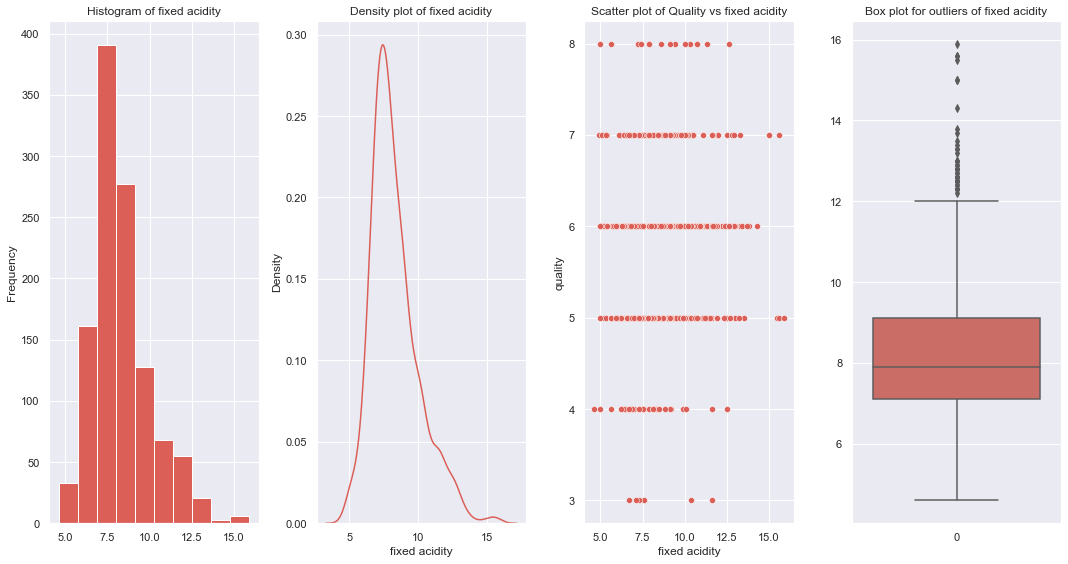

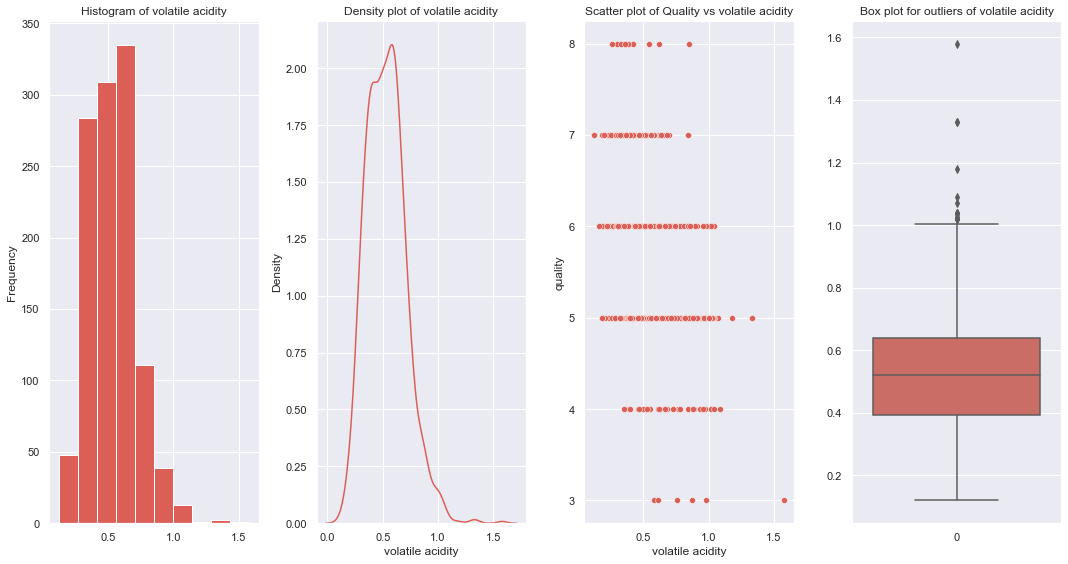

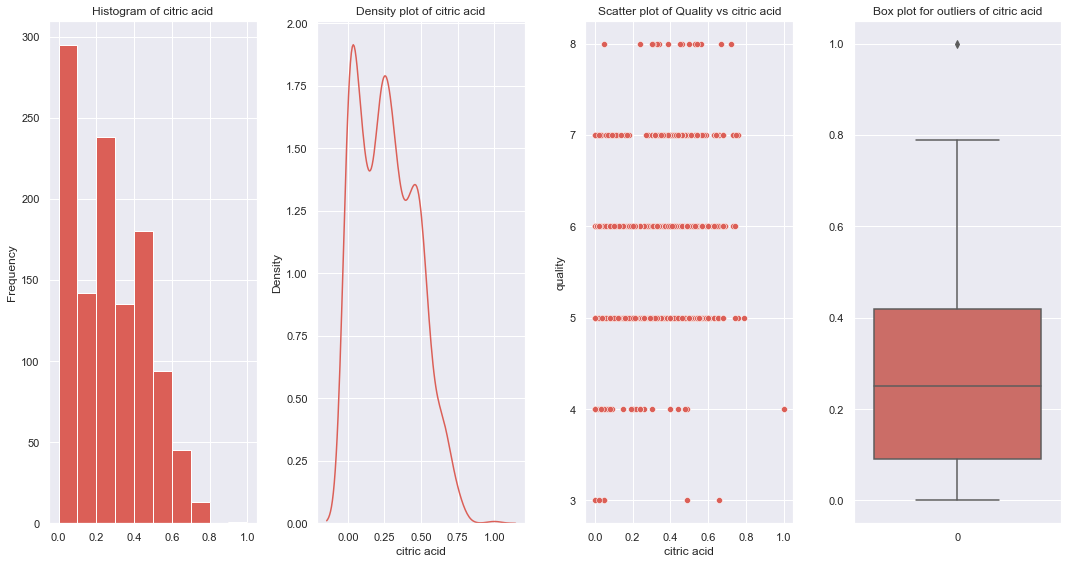

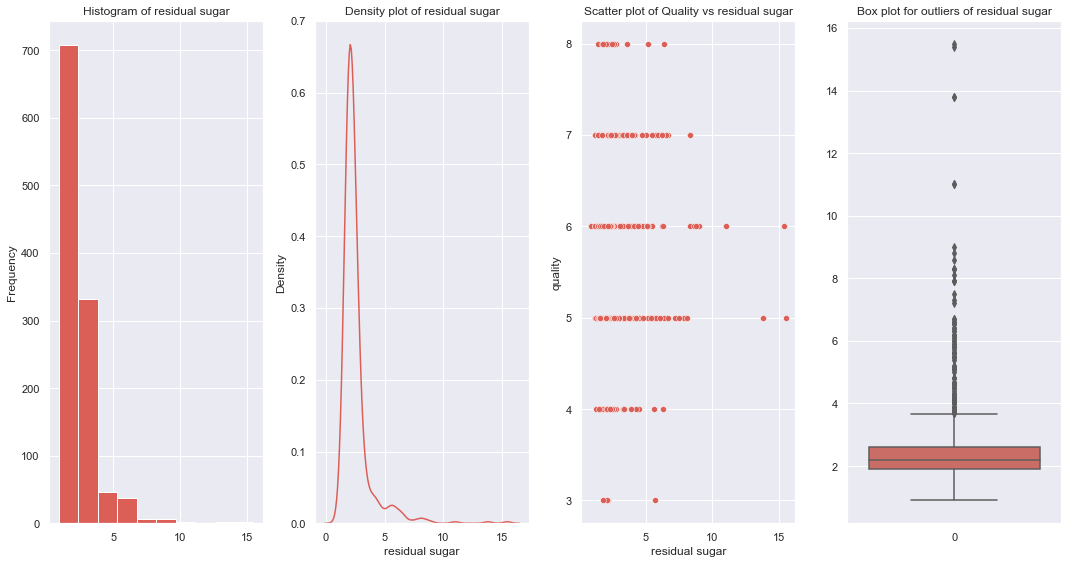

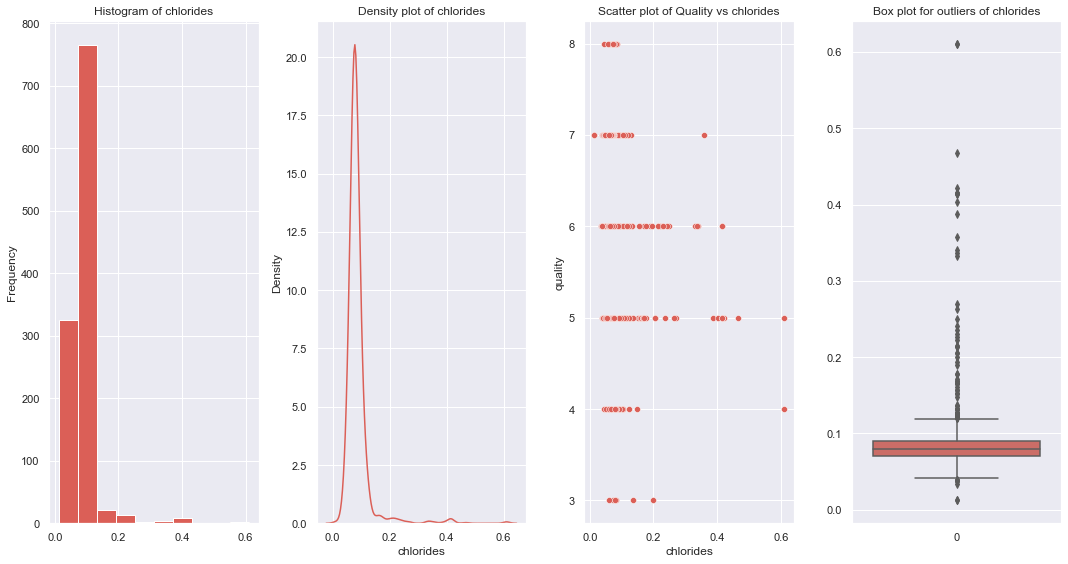

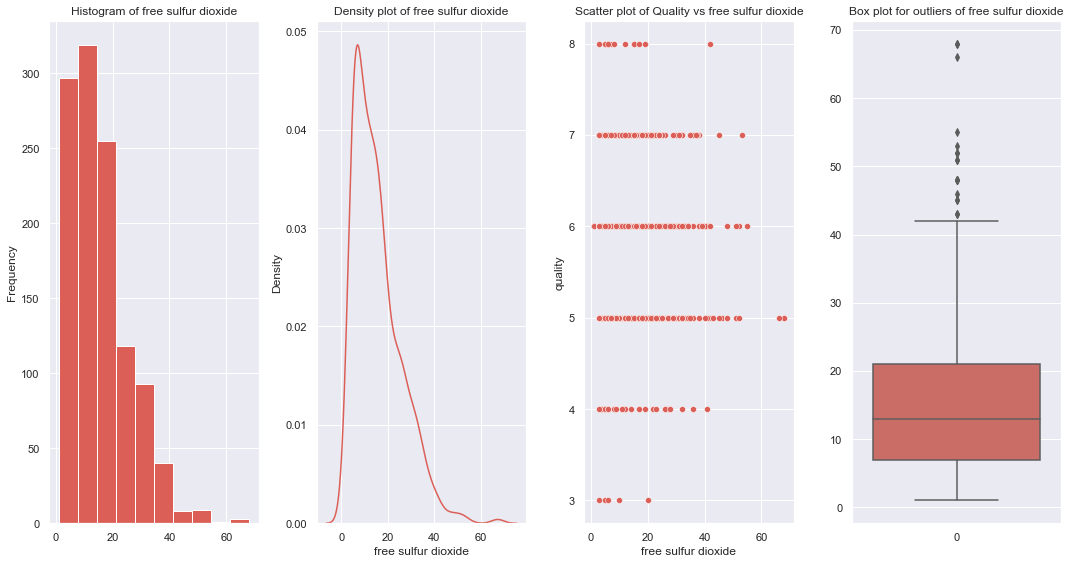

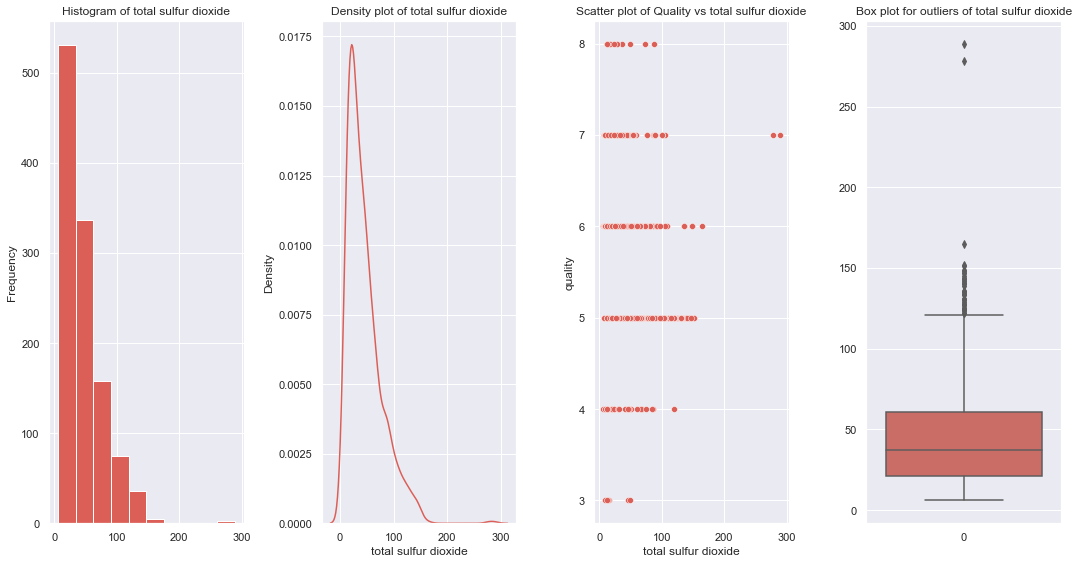

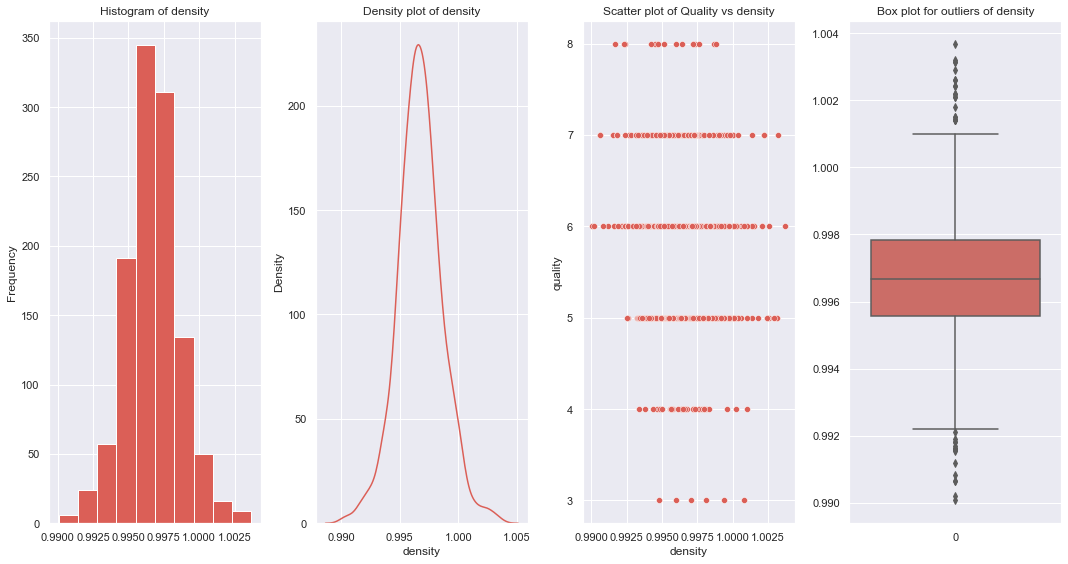

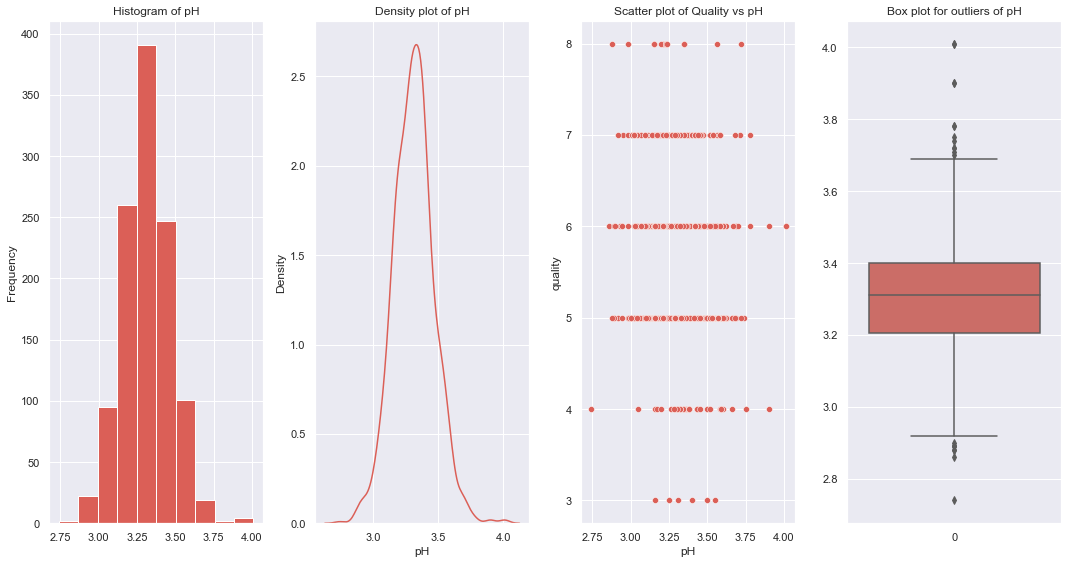

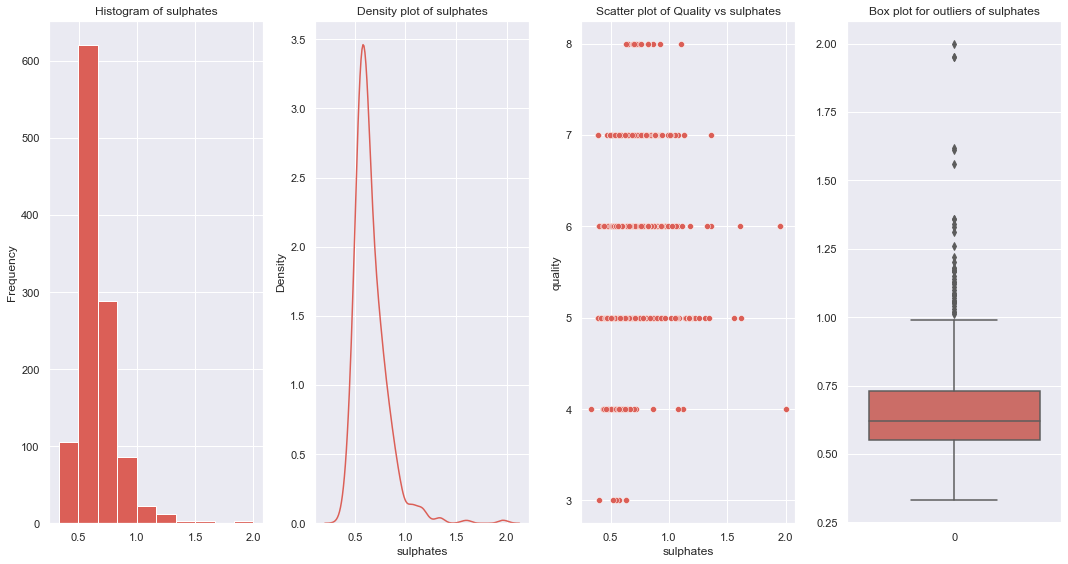

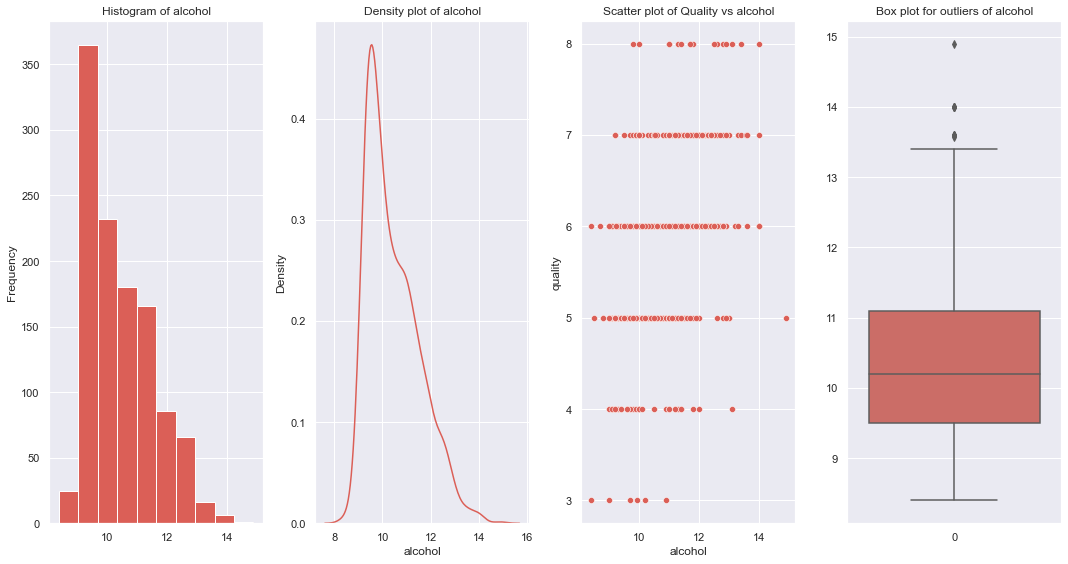

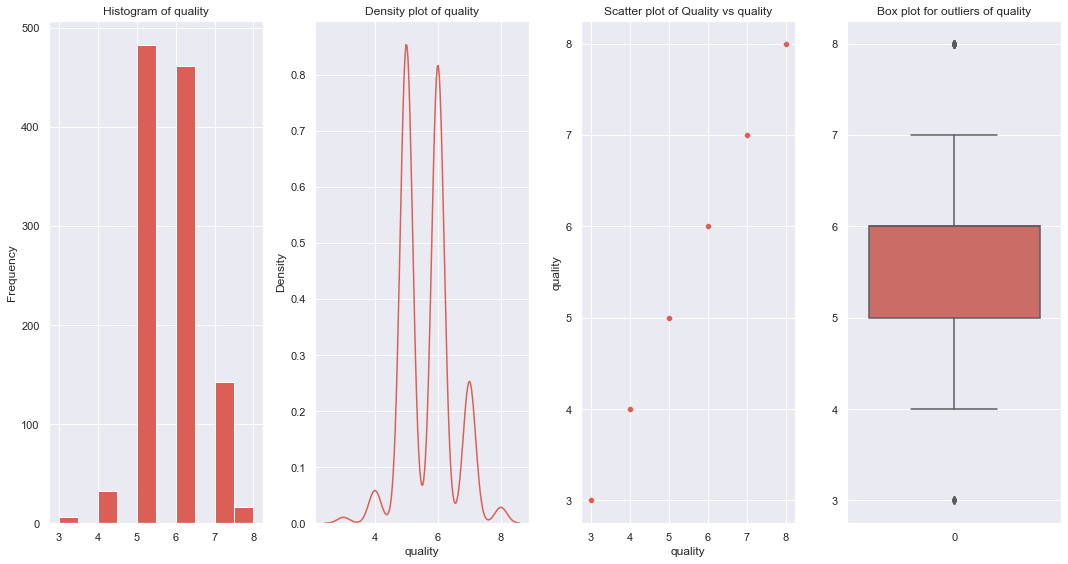

In [8]:
for column in df.columns:
    visualize_column(column)

In terms of normality we can see that most of the features are either close to normal, normal with some skew, or in a few cases definitevly not normal. Because of this varying state of normality we need to avoid any machine learning algorithms that rely on the normality of input features (such as linear regression).

## Data Cleaning

Since almost all of the features had more than 5 outliers we are going to want to choose a normalization method that is able to handle them. This will be accomplished by using the Robust Scaler from the sklearn library.

First we will begin by seperating our label, then we will drop all of the columns that had insufficient correlation to make it into the model.

In [9]:
y = df["quality"]
X = df.drop(["quality", "free sulfur dioxide", "residual sugar", "pH"], axis = 1)


Next we will normalize our data using the Robust Scaler from sklearn, which is good at handling datasets with lots of outliers.

In [10]:
scaler = RobustScaler()
X = scaler.fit_transform(X)

From the quality graph in our feature exploration we saw that the quality wasn't equally distributed throughout all of the possible identification classes. Because of this we will need to create additional "faux" data points through the SMOTE method from the imbalanced-learner library.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='quality', ylabel='count'>

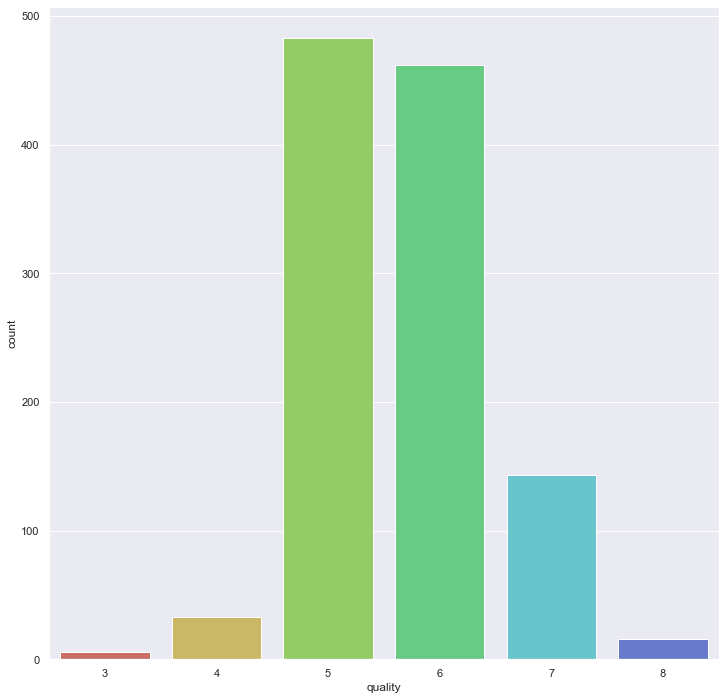

In [11]:
sns.countplot(y)

First we begin by splitting the data into training and test sets using the sklearn train_test_split method. This is done before using the SMOTE method to prevent creating unrealistic testing conditions for our algorithm. The idea is to manipulate the testing data as little as possible.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 84)
oversample = SMOTE(k_neighbors = 4)
X_train, y_train = oversample.fit_resample(X_train, y_train)

## Model Training

### Support Vector Classifier

The first model we will atempt is a Support Vector Classifier with hyperparameters tuned through GridSearchCV from the sklearn library.

In [13]:
parameters = {'C' : np.arange(0.1, 1, 0.1),
              'gamma' : np.arange(0.1, 1, 0.1),
              'kernel' : ['rbf', 'linear', 'poly', 'sigmoid']
             }
svc = SVC(random_state = 147)
classifier = GridSearchCV(svc, parameters, scoring = "accuracy")
classifier.fit(X_train, y_train)

GridSearchCV(estimator=SVC(random_state=147),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
             scoring='accuracy')

The ideal value for both C and Gamma is 0.9 while the ideal kernel of the options presented is the rbf kernel

In [14]:
print(classifier.best_params_)
print(classifier.best_score_)

{'C': 0.9, 'gamma': 0.9, 'kernel': 'rbf'}
0.8383199433619601


In [34]:
test_predictions = classifier.predict(X_test)
confusion = confusion_matrix(y_test, test_predictions)
accuracy = accuracy_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions, average = 'weighted')
precision = precision_score(y_test, test_predictions, average = 'weighted')
f1 = f1_score(y_test, test_predictions, average = 'weighted')
SVC_results = [accuracy, recall, precision, f1]

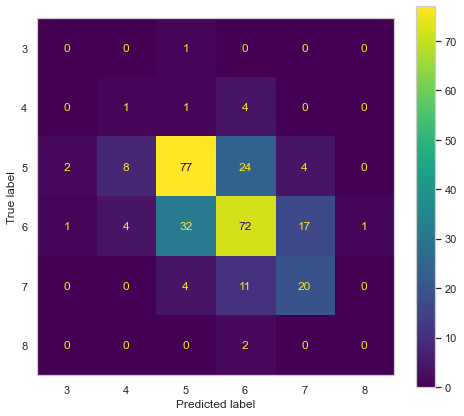

In [16]:
sns.set(rc={"figure.figsize":(8, 7)})
sns.set_style("whitegrid", {'axes.grid' : False})
ConfusionMatrixDisplay.from_estimator(classifier.best_estimator_, X_test, y_test)

The results of the SVC show an accuracy just about 60% with recall, precision, and f1 to match. This isn't incredibly surprising for two reasons, the first is our small dataset and the second is the ordinal nature of the classifications we are trying to predict.

In that light it is worth while to examine if the predictions we are making are off by more than 1 in the ordinal classification regularly or if the classifier is usually predicting within 1 degree of quality.
From the data we can see that the total number of predictions that were more than 1 degree of quality away from the true value is 23 out of 286, meaning that the accuracy in terms of 1 degree off is ~92%.

In [17]:
print(f"accuracy score is {accuracy}")
print(f"recall score is {recall}")
print(f"precision score is {precision}")
print(f"f1 score is {f1}")

accuracy score is 0.5944055944055944
recall score is 0.5944055944055944
precision score is 0.6134792418725408
f1 score is 0.6022819285977181


### Random Forest Classifier
Next we will look at a Random Forest Classifier with hyperparameters tuned by Grid Search CV.

In [18]:
parameters = {
    "n_estimators" : [x for x in range(1,100, 2)],
    "criterion" : ['gini', 'entropy']    
}

rfc = RFC(random_state = 147)
classifier = GridSearchCV(rfc, parameters, scoring = "accuracy")
classifier.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=147),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39,
                                          41, 43, 45, 47, 49, 51, 53, 55, 57,
                                          59, ...]},
             scoring='accuracy')

The Grid Search CV identified the gini criterion and 73 estimators as the best hyperparameters.

In [19]:
print(classifier.best_params_)
print(classifier.best_score_)

{'criterion': 'gini', 'n_estimators': 73}
0.8591539179774476


Our Random Forest Classifier gives an accuracy of 62.2% which is slightly better than the SVC but is not a significant improvement. Again this could be a result of the lack of data points or this could be a result of the relatively low number of features to select from which prevents the RFC from diversifying in the standard fashion.

In [35]:
test_predictions = classifier.predict(X_test)
rf_confusion = confusion_matrix(y_test, test_predictions)
rf_accuracy = accuracy_score(y_test, test_predictions)
rf_recall = recall_score(y_test, test_predictions, average = 'weighted')
rf_precision = precision_score(y_test, test_predictions, average = 'weighted')
rf_f1 = f1_score(y_test, test_predictions, average = 'weighted')

In [36]:
print(f"accuracy score is {rf_accuracy}")
print(f"recall score is {rf_recall}")
print(f"precision score is {rf_precision}")
print(f"f1 score is {rf_f1}")
rand_forest_results = [rf_accuracy, rf_recall, rf_precision, rf_f1]

accuracy score is 0.3776223776223776
recall score is 0.3776223776223776
precision score is 0.5748621311535828
f1 score is 0.4402231850113348


The confusion matrix for the Random forest classifier looks like there is a pretty tight clustering around the true values, but we can see that in the case for the truth label of 6 we get predictions that run the entire range of values, from 3 to 8. This is an unfortunate result and tweaking the hyperparameters to limit the spread of the predictions would be important before using this model for any real world situations.
Out of the 286 predictions only 18 were classified more than one ordinal degree away from their true value. This is ~93.7% accurate.

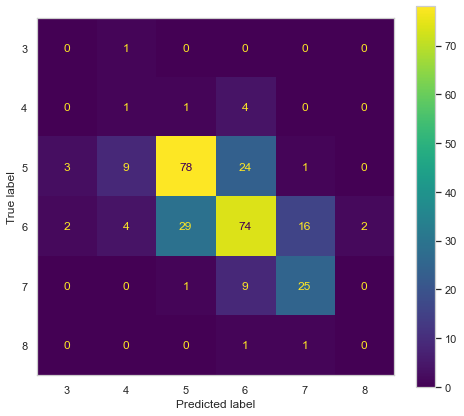

In [22]:
ConfusionMatrixDisplay.from_estimator(classifier.best_estimator_, X_test, y_test)

### Logistic Regression Classifier

Finally we will consider a logistic regression classifier.

In [23]:
from sklearn.linear_model import LogisticRegression


parameters = {
    "solver" : ["newton-cg", "sag", "saga"],
}

lrc = LogisticRegression(random_state = 1187)
classifier = GridSearchCV(lrc, parameters, scoring = "accuracy")
classifier.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

GridSearchCV(estimator=LogisticRegression(random_state=1187),
             param_grid={'solver': ['newton-cg', 'sag', 'saga']},
             scoring='accuracy')

Grid Search CV returned the newton-cg solver as the best hyperparameter, 

In [24]:
print(classifier.best_params_)
print(classifier.best_score_)

{'solver': 'newton-cg'}
0.6032731041134403


The logistic regression classifier performed incredibly poorly compared to the other two algorithms. With an accuracy below 40% we can definitively eliminate a logistic regression classifier from our options of predictive models for this data set.

In [25]:
test_predictions = classifier.predict(X_test)
lrc_confusion = confusion_matrix(y_test, test_predictions)
lrc_accuracy = accuracy_score(y_test, test_predictions)
lrc_recall = recall_score(y_test, test_predictions, average = 'weighted')
lrc_precision = precision_score(y_test, test_predictions, average = 'weighted')
lrc_f1 = f1_score(y_test, test_predictions, average = 'weighted')

In [37]:
print(f"accuracy score is {lrc_accuracy}")
print(f"recall score is {lrc_recall}")
print(f"precision score is {lrc_precision}")
print(f"f1 score is {lrc_f1}")
log_reg_results = [lrc_accuracy, lrc_recall, lrc_precision, lrc_f1]

accuracy score is 0.3776223776223776
recall score is 0.3776223776223776
precision score is 0.5748621311535828
f1 score is 0.4402231850113348


The confusion matrix tells the unfortunate story of the logistic regression classifier: not only are the predictions wrong they are often wrong by more than one ordinal degree. The result is that the number of samples misclassified by more than one degree is 49 out of 286 samples, ~82.8%. This is best shown when the true label is either 5 or 6, we can see predictions ranging from 3 to 8 for both truth labels. Simply put this is a poor performing model making wild predictions from the input data.

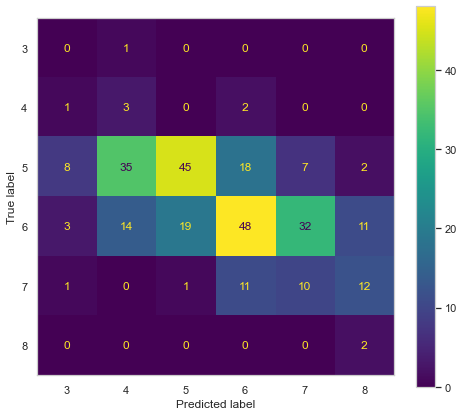

In [27]:
ConfusionMatrixDisplay.from_estimator(classifier.best_estimator_, X_test, y_test)

## Results

When compared side by side the metrics for the Random Forest Classifier out perform the other two algorithms in all four measured metrics. Howeve between the SVC and RFC the difference is small enough to suggest it is the result of chance rather than being a superior model.

In [38]:
SVC_results.append(.92)
rand_forest_results.append(.937)
log_reg_results.append(.828)

In [39]:
results_df_dict = {"SVC":SVC_results, "RFC":rand_forest_results, "LogReg":log_reg_results}
results_df = pd.DataFrame(data=results_df_dict, index = ["accuracy", "recall", "precision", "f1", "Within one Degree Accuracy"])

In [40]:
print(results_df)

                                 SVC       RFC    LogReg
accuracy                    0.377622  0.377622  0.377622
recall                      0.377622  0.377622  0.377622
precision                   0.574862  0.574862  0.574862
f1                          0.440223  0.440223  0.440223
Within one Degree Accuracy  0.920000  0.937000  0.828000


## Discussion and Conclusion

None of the three models performed very well, but two of them were at least making predictions in close to the appropriate class. The Random Forest Classifier and the Support Vector Classifier were able to narrow the window down to within one ordinal degree more than 90% of the time. This is an excellent start, but further research would need to accomplish three things:

    1. Increase the number of data points to help reduce the impact of outliers and edge cases
    2. Balance the data set with approximately equal numbers of quality results to prevent the neccesitation of the
       Smote method
    3. Find a way to incorporate a more diverse range of features, especially focusing on traditional predictors of        quality such as style, region, and aging which could explain some of the variation in the quality data.

As it stands currently these models are from being usable, but they have illuminated one interesting question in this analysis, when classifying ordinal data, why aren't there options to accomplish this natively with sklearn supervised algorithms? Research during this project suggests that this might be because there ins't a universally agreed on, or even set of good contenders for accounting for the ordinality of classification labels.